# Modelo LDA (Latent Dirichlet Allocation)

El modelo LDA (Latent Dirichlet Allocation) es una técnica de modelado de temas que permite descubrir tópicos en grandes colecciones de textos. Introducido en 2003 por los investigadores David Blei, Andrew Ng y Michael Jordan. Este modelo probabilístico asume que cada documento dentro de un corpus es una combinación de múltiples temas, y que cada tema se caracteriza por una distribución específica de palabras. A través de este enfoque, LDA facilita la identificación de estructuras subyacentes en los datos textuales.

- Blei, D. M., Ng, A. Y., & Jordan, M. I. (2003). Latent Dirichlet Allocation. Journal of Machine Learning Research, 3, 993-1022. [Enlace al artículo](http://www.jmlr.org/papers/volume3/blei03a/blei03a.pdf)

## Fórmulas

El modelo LDA se basa en las siguientes distribuciones:

1. **Distribución de Dirichlet**: 
    $$
    \theta \sim \text{Dirichlet}(\alpha)
    $$
    Donde $\theta$ es la distribución de temas en un documento y $\alpha$ es el parámetro de Dirichlet que controla la distribución de temas en los documentos.

2. **Distribución de temas**:
    $$ 
    z \sim \text{Categorical}(\theta)
    $$
    Donde $z$ es el tema asignado a una palabra en un documento.

3. **Distribución de palabras**:
    $$
    w \sim \text{Categorical}(\beta_z)
    $$
    Donde $w$ es la palabra observada y $\beta_z$ es la distribución de palabras para el tema $z$.

El objetivo del modelo LDA es inferir las distribuciones $\theta$ y $\beta$ a partir del corpus de textos. Esto se realiza mediante técnicas de inferencia como Gibbs Sampling o Variational Inference.

## Fórmula Bayesiana

La inferencia en el modelo LDA se basa en la fórmula de Bayes:

$$
P(\theta, z | w, \alpha, \beta) = \frac{P(w | z, \beta) P(z | \theta) P(\theta | \alpha)}{P(w | \alpha, \beta)}
$$

Donde:
- $P(\theta, z | w, \alpha, \beta)$ es la distribución posterior de los parámetros y las variables latentes.
- $P(w | z, \beta)$ es la probabilidad de las palabras dadas las asignaciones de temas y las distribuciones de palabras.
- $P(z | \theta)$ es la probabilidad de las asignaciones de temas dadas las distribuciones de temas.
- $P(\theta | \alpha)$ es la probabilidad de las distribuciones de temas dadas las hiperparámetros de Dirichlet.
- $P(w | \alpha, \beta)$ es la probabilidad marginal de las palabras dadas las hiperparámetros.

Esta fórmula permite actualizar nuestras creencias sobre las distribuciones de temas y palabras a medida que observamos más datos.

![LDA Model](./image.png)


In [ ]:
import pandas as pd
import re
import string
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

def remove_numbers(text):
    text = re.sub(r"[0-9]", " ", text)
    return " ".join(text.split())

def remove_unprintable_(text):
    printable = set(string.printable + "ñáéíóúü" + "ÑÁÉÍÓÚÜ")
    text = "".join(filter(lambda x: x in printable, text))
    return text

def remove_punctuation(text):
    pattern = re.compile(r"[^\w\sáéíóúüñÁÉÍÓÚÜÑ]")
    t = pattern.sub(r" ", text)
    return re.sub(" +", " ", t)

def reduce_spam(text):
    text = re.sub(r"(\w+)(\s+\1){2,}", r"\1", text)
    text = re.sub(r"(\w+\s+\w+)(\s+\1){2,}", r"\1", text)
    return text

def remove_vowels_accents(text):
    return (
        text.replace("á", "a")
        .replace("é", "e")
        .replace("í", "i")
        .replace("ó", "o")
        .replace("ú", "u")
        .replace("ü", "u")
    )

def remove_stopwords(text, stopwords_list):
    return " ".join(
        [word for word in str(text).split() if word not in stopwords_list]
    )

def clean_text(text):
    text = text.lower()
    text = remove_numbers(text)
    text = remove_unprintable_(text)
    text = remove_punctuation(text)
    text = reduce_spam(text)
    text = remove_stopwords(text, stopwords_list)
    text = remove_vowels_accents(text)
    return text.strip()

def load_stopwords(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        stopwords = file.read().splitlines()
    return stopwords

stopwords_list = load_stopwords("stopwords.txt")
stopwords_list = [word.lower() for word in stopwords_list]


file_path = "01_bbdd_think_tanks.xlsx"
df = pd.read_excel(file_path)


In [ ]:
think_tank = "Pivotes" 

df['FechaPublicación'] = pd.to_datetime(df['FechaPublicación'], errors='coerce', format='%Y-%m-%d')

start_date = "2023-11-01"
end_date = "2023-12-31"
mask = (df['FechaPublicación'] >= start_date) & (df['FechaPublicación'] <= end_date) & (df['Think Tank'] == think_tank)
df_filtered = df.loc[mask].copy()

df_filtered['Corpus'] = df_filtered['Corpus'].dropna().apply(clean_text)
df_filtered = df_filtered.dropna(subset=['Corpus'])
documents = df_filtered['Corpus'].tolist()

vectorizer = CountVectorizer(stop_words=stopwords_list)
X = vectorizer.fit_transform(documents)

lda = LatentDirichletAllocation(
    n_components=6,
    random_state=23434
    )

lda.fit(X)


Topic 0:
educacion sistema años politico reformas
Topic 1:
años crisis politico publico constitucional
Topic 2:
laboral salmonicultura industria año contratacion
Topic 3:
ambiental sistema pivotes crisis crecimiento
Topic 4:
propuesta constitucion sistema politico constitucional
Topic 5:
gobierno pensiones sala reforma cuna


In [ ]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 5
display_topics(lda, vectorizer.get_feature_names_out(), no_top_words)

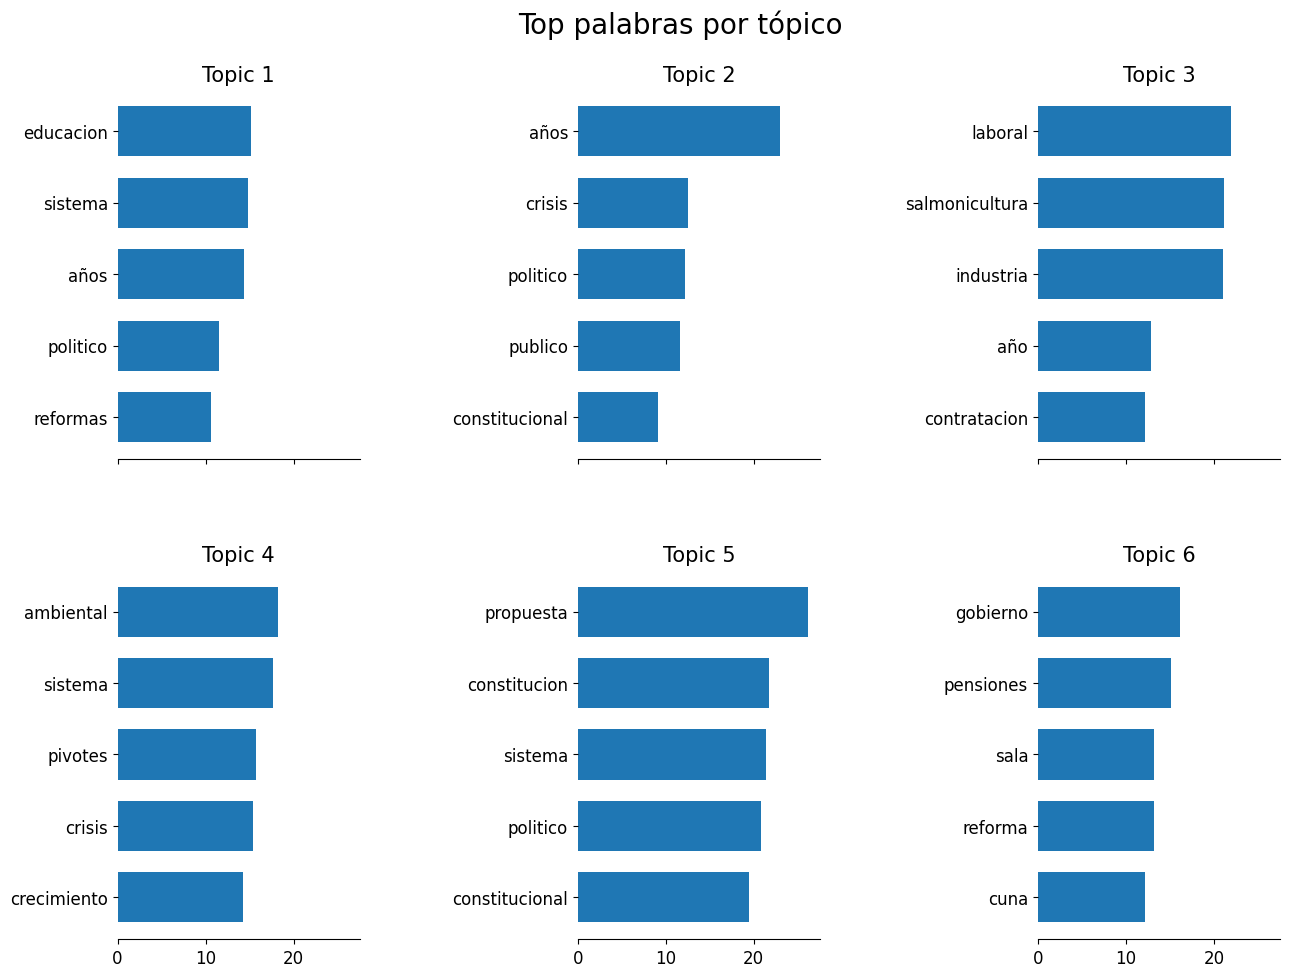

In [5]:
import matplotlib.pyplot as plt

def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 3, figsize=(15, 10), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx + 1}', fontdict={'fontsize': 15})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=12)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=20)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

plot_top_words(lda, vectorizer.get_feature_names_out(), no_top_words, 'Top palabras por tópico')





# Método TF-IDF (Term Frequency-Inverse Document Frequency)

El método TF-IDF (Term Frequency-Inverse Document Frequency) es una técnica  para evaluar la importancia de una palabra en un documento dentro de un corpus. Introducido por Karen Spärck Jones en 1972, TF-IDF combina dos métricas: la frecuencia de término (TF) y la frecuencia inversa de documento (IDF).

## Fórmulas

1. **Frecuencia de Término (TF)**:
    $$
    \text{TF}(t, d) = \frac{f_{t,d}}{N_d}
    $$
    Donde $f_{t,d}$ es el número de veces que el término $t$ aparece en el documento $d$, y $N_d$ es el número total de términos en el documento $d$.

2. **Frecuencia Inversa de Documento (IDF)**:
    $$
    \text{IDF}(t, D) = \log \left( \frac{N}{|d \in D : t \in d|} \right)
    $$
    Donde $N$ es el número total de documentos en el corpus $D$, y $|d \in D : t \in d|$ es el número de documentos en los que aparece el término $t$.

3. **TF-IDF**:
    $$
    \text{TF-IDF}(t, d, D) = \text{TF}(t, d) \times \text{IDF}(t, D)
    $$


El valor TF-IDF aumenta proporcionalmente al número de veces que una palabra aparece en un documento, pero se compensa por la frecuencia de la palabra en el corpus, lo que ayuda a ajustar el hecho de que algunas palabras son generalmente más comunes que otras. Este método es especialmente útil para identificar palabras que son importantes en un documento pero no comunes en el resto del corpus.

- **TF** mide la frecuencia de un término en un documento específico.
- **IDF** mide la importancia del término en el corpus completo, reduciendo el peso de términos comunes.



Aplicar TF-IDF en un corpus de documentos permite identificar términos relevantes y mejorar la precisión en tareas como la clasificación de textos, la búsqueda de información y la extracción de características. Al ponderar los términos de esta manera, se pueden destacar las palabras que son más significativas para el contenido de un documento en particular.

- Spärck Jones, K. (1972). A statistical interpretation of term specificity and its application in retrieval. Journal of Documentation, 28(1), 11-21. (https://www.researchgate.net/publication/220374297_A_statistical_interpretation_of_term_specificity_and_its_application_in_retrieval)


In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(stop_words=stopwords_list, ngram_range=(3, 3))
tfidf_X = tfidf_vectorizer.fit_transform(documents)

tfidf_sum = tfidf_X.sum(axis=0)
tfidf_sum = tfidf_sum.A1 

tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

no_top_words = 20

sorted_items = tfidf_sum.argsort()[::-1]
tfidf_top_words = [tfidf_feature_names[i] for i in sorted_items[:no_top_words]]

print("TF-IDF Top Words for the entire corpus:")
print(" ".join(tfidf_top_words))

TF-IDF Top Words for the entire corpus:
sistema politico estructura directora evidencia pivotes despido renuncia voluntaria traduce empleos mejores laboral implementado medidas laboral ingreso minimo laboral traduce empleos trabajador reciba caso bajaria costos contratacion facilitan contratacion alza crear mejores empleos evento trabajador reciba reducir indemnizacion despido oecd hacerla evento reimpulsen economia permitan espacio mejorar reducir esfuerzos medidas reimpulsen renuncia voluntaria bajaria alza salario minimo costos contratacion permitiria


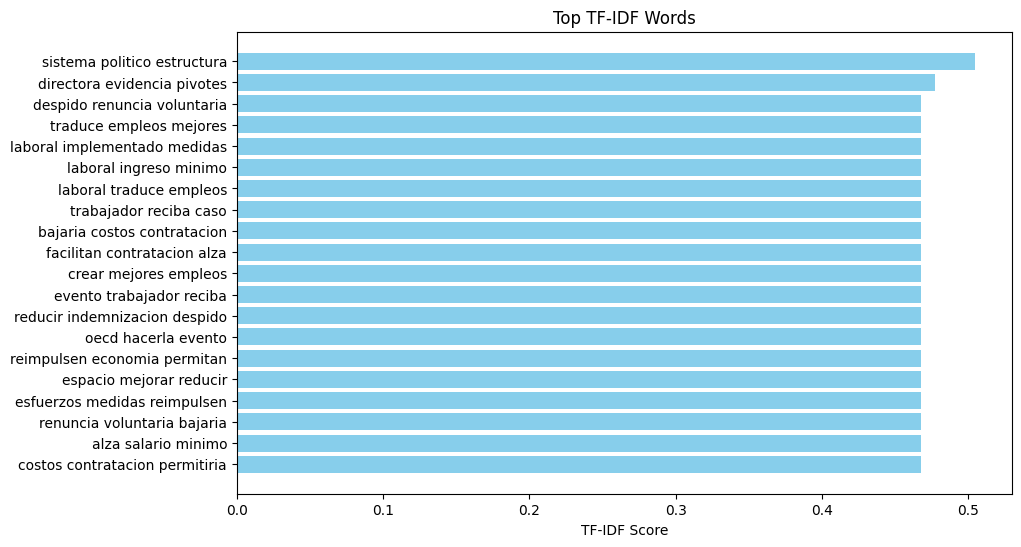

In [7]:
import matplotlib.pyplot as plt

def plot_tfidf_top_words(tfidf_top_words, tfidf_sum, tfidf_feature_names, no_top_words):
    top_indices = [tfidf_feature_names.tolist().index(word) for word in tfidf_top_words]
    top_scores = [tfidf_sum[i] for i in top_indices]

    plt.figure(figsize=(10, 6))
    plt.barh(tfidf_top_words, top_scores, color='skyblue')
    plt.xlabel('TF-IDF Score')
    plt.title('Top TF-IDF Words')
    plt.gca().invert_yaxis()
    plt.show()

plot_tfidf_top_words(tfidf_top_words, tfidf_sum, tfidf_feature_names, no_top_words)